### **Laboratorio 5**

- Juan Pablo Solis
- Isabella Miralles

In [27]:
import pandas as pd

train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

train_df.head()


Train shape: (7613, 5)
Test shape: (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [28]:
nan_percentage = train_df[['keyword', 'location']].isna().mean() * 100
print(nan_percentage)


keyword      0.801261
location    33.272035
dtype: float64


In [29]:
train_df = train_df.drop(columns=['location'])
test_df = test_df.drop(columns=['location'])
train_df.head()


,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Se decidio eliminar la columna location debido a que tenia un 33% de NaN, en comparacion a Keyword el cual tiene solo un 0.8%.

#### **Preprocesamiento de datos**

In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    
    text = re.sub(r'http\S+|www.\S+', '', text)
    
    text = re.sub(r'[@#]', '', text)
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    text = re.sub(r'\d+', '', text)
    
    text = re.sub(r'[^a-z\s]', '', text)
    
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

clean_train = train_df.copy()
clean_test = test_df.copy()

clean_train['text'] = clean_train['text'].apply(clean_text)
clean_test['text'] = clean_test['text'].apply(clean_text)

clean_train = clean_train[['keyword', 'text', 'target']]
clean_test = clean_test[['keyword', 'text']]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
clean_test.head()

,keyword,text
0,NaN,happened terrible car crash
1,NaN,heard earthquake different cities stay safe ev...
2,NaN,forest fire spot pond geese fleeing across str...
3,NaN,apocalypse lighting spokane wildfires
4,NaN,typhoon soudelor kills china taiwan


#### **Frecuencia de palabras**

In [32]:
from collections import Counter


disaster_tweets = clean_train[clean_train['target'] == 1]['text']
non_disaster_tweets = clean_train[clean_train['target'] == 0]['text']


disaster_words = " ".join(disaster_tweets).split()
non_disaster_words = " ".join(non_disaster_tweets).split()


disaster_freq = Counter(disaster_words).most_common(20)
non_disaster_freq = Counter(non_disaster_words).most_common(20)

print("Palabras más frecuentes en tweets de desastres:\n", disaster_freq)
print("\nPalabras más frecuentes en tweets NO desastres:\n", non_disaster_freq)


Palabras más frecuentes en tweets de desastres:
 [('fire', 180), ('news', 140), ('via', 121), ('disaster', 117), ('california', 111), ('suicide', 110), ('police', 107), ('amp', 107), ('people', 105), ('killed', 93), ('like', 92), ('pm', 89), ('hiroshima', 89), ('storm', 85), ('us', 84), ('crash', 84), ('fires', 84), ('families', 81), ('train', 79), ('emergency', 76)]

Palabras más frecuentes en tweets NO desastres:
 [('like', 253), ('im', 248), ('amp', 193), ('new', 170), ('get', 163), ('dont', 154), ('one', 128), ('body', 113), ('via', 99), ('would', 97), ('video', 96), ('people', 91), ('love', 90), ('cant', 86), ('us', 86), ('time', 85), ('know', 85), ('back', 84), ('got', 83), ('see', 82)]


El análisis de frecuencias muestra que en los tweets de desastres predominan palabras como fire, disaster, killed, storm, crash, emergency y police, las cuales están directamente relacionadas con situaciones críticas y resultan muy útiles para un modelo de clasificación, mientras que en los tweets que no corresponden a desastres destacan términos cotidianos como like, im, love, get o day, que reflejan conversaciones normales sin relación a emergencias. Por esta razón, las palabras asociadas a eventos catastróficos son las que más valor aportan para diferenciar las clases.

Se decidio que si vale la pena explorar biagramas, ya que aportan contexto más específico y reducen ambigüedad; por ejemplo, un unigramas como fire puede ser confuso, pero expresiones como forest fire o category 5 hurricane delimitan con mayor claridad la temática de desastre, lo que puede mejorar la precisión del modelo

#### **Analisis exploratorio**

In [33]:
print("Más frecuente en desastres:", disaster_freq[0])
print("Más frecuente en no desastres:", non_disaster_freq[0])


Más frecuente en desastres: ('fire', 180)
Más frecuente en no desastres: ('like', 253)


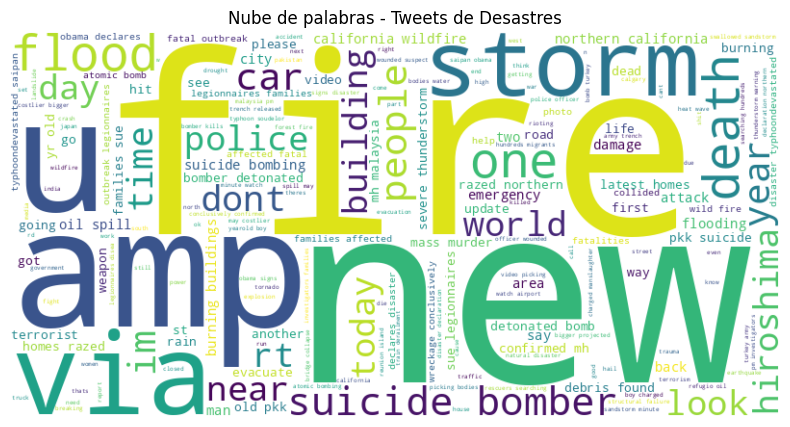

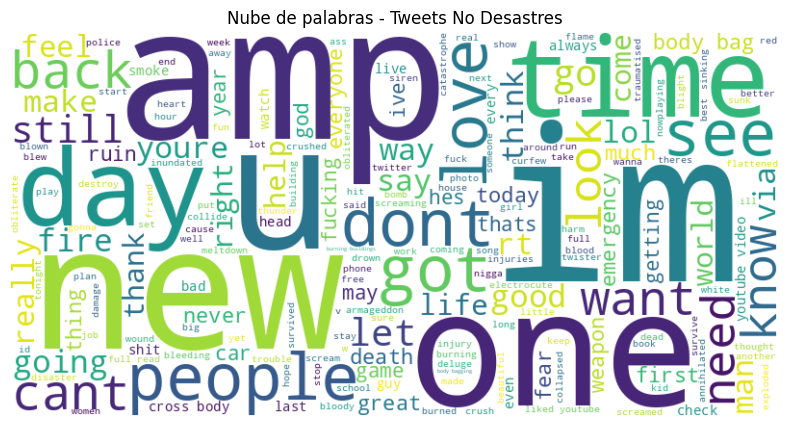

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Wordcloud desastres
wc_disaster = WordCloud(width=800, height=400, background_color="white").generate(" ".join(disaster_words))
plt.figure(figsize=(10,5))
plt.imshow(wc_disaster, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Tweets de Desastres")
plt.show()

# Wordcloud no desastres
wc_non = WordCloud(width=800, height=400, background_color="white").generate(" ".join(non_disaster_words))
plt.figure(figsize=(10,5))
plt.imshow(wc_non, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Tweets No Desastres")
plt.show()


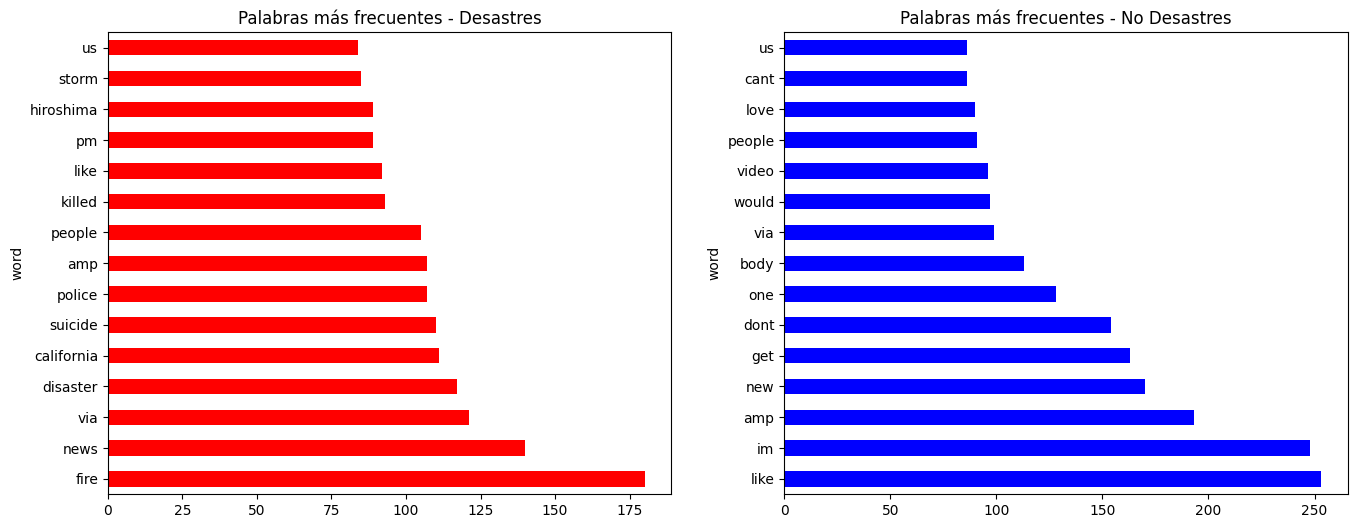

In [ ]:
import pandas as pd

# Top 15 palabras desastres
disaster_df = pd.DataFrame(disaster_freq[:15], columns=["word", "count"])
non_disaster_df = pd.DataFrame(non_disaster_freq[:15], columns=["word", "count"])

fig, axes = plt.subplots(1, 2, figsize=(16,6))

disaster_df.plot(kind="barh", x="word", y="count", ax=axes[0], color="red", legend=False)
axes[0].set_title("Palabras más frecuentes - Desastres")

non_disaster_df.plot(kind="barh", x="word", y="count", ax=axes[1], color="blue", legend=False)
axes[1].set_title("Palabras más frecuentes - No Desastres")

plt.show()


Se observa que ciertas palabras aparecen con frecuencia tanto en tweets de desastres como en los que no lo son. Ejemplos claros son “us”, “people”, “like”, “via” y “amp”. Estas palabras no son exclusivas de un contexto de emergencia, sino que reflejan lenguaje general o estructuras propias de Twitter. Por esa razón, aunque son frecuentes, no resultan muy discriminantes para diferenciar entre tweets de desastre y no desastre.

En cambio, existen palabras que sí marcan una diferencia clara entre categorías. En los tweets de desastres destacan términos como “fire”, “disaster”, “killed”, “storm”, “emergency” y “suicide”, que aportan información directamente relacionada con eventos catastróficos y son fuertes candidatos a servir como features relevantes para el modelo de clasificación. Por el contrario, en los tweets que no son de desastres predominan palabras como “love”, “im”, “cant”, “video” y “day”, ligadas a conversaciones cotidianas, emociones o entretenimiento.

En conclusión, aunque las palabras comunes aparecen en ambos conjuntos, no ayudan mucho a la clasificación porque carecen de especificidad. Lo que realmente aporta valor son los términos exclusivos o fuertemente asociados a cada categoría.